In [1]:
!pip uninstall pyTigerGraph -y
!pip install git+https://github.com/tigergraph/pyTigerGraph.git --no-cache

Found existing installation: pyTigerGraph 1.2.6
Uninstalling pyTigerGraph-1.2.6:
  Successfully uninstalled pyTigerGraph-1.2.6
  Cloning https://github.com/tigergraph/pyTigerGraph.git to /tmp/pip-req-build-jd_wqmo6
  Running command git clone --filter=blob:none --quiet https://github.com/tigergraph/pyTigerGraph.git /tmp/pip-req-build-jd_wqmo6
  Resolved https://github.com/tigergraph/pyTigerGraph.git to commit 886de415393d16d7ffab8f90824d2a7e34b8b16a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyTigerGraph: filename=pyTigerGraph-1.2.6-py3-none-any.whl size=135918 sha256=e55deb6cea85cded360af16caa5886e2275b8e570a4799732fb69abf7b5eb6ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-7606alh1/wheels/cc/41/7a/6b8eee74c439c99b3cdb01357d4b426b9a18e51e9571b28b18
Successfully built pyTigerGraph


# NodePiece - Heterogenous GraphSAGE
This notebook demonstrates the training of a Heterogenous GraphSAGE model with trainable embeddings using the NodePiece algorithm.  We train the model on the IMDB dataset from [PyG datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.IMDB) with TigerGraph as the data store. The dataset contains 3 types of vertices: 4278 movies, 5257 actors, and 2081 directors; and 4 types of edges: 12828 actor to movie edges, 12828 movie to actor edges, 4278 director to movie edges, and 4278 movie to director edges. Each vertex is described by a 0/1-valued word vector indicating the absence/presence of the corresponding keywords from the plot (for movie) or from movies they participated (for actors and directors). Each movie is classified into one of three classes, action, comedy, and drama according to their genre. The goal is to predict the class of each movie in the graph.

## Table of Contents
* [Data Processing](#data_processing)  
* [NodePiece Algorithm](#nodepiece_algorithm)
* [Train on neighborhood subgraphs](#train_subgraph)  
* [Inference](#inference)
* [Embedding Visualization](#viz)

## Data Processing <a name="data_processing"></a>

### Connect to TigerGraph

The `TigerGraphConnection` class represents a connection to the TigerGraph database. Under the hood, it stores the necessary information to communicate with the database. It is able to perform quite a few database tasks. Please see its [documentation](https://docs.tigergraph.com/pytigergraph/current/intro/) for details.

To connect your database, modify the `config.json` file accompanying this notebook. Set the value of `getToken` based on whether token auth is enabled for your database. Token auth is always enabled for tgcloud databases. 

In [2]:
from pyTigerGraph import TigerGraphConnection
import json

# Read in DB configs
with open('../config.json', "r") as config_file:
    config = json.load(config_file)
    
conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"]
)

### Ingest Data

In [3]:
from pyTigerGraph.datasets import Datasets

dataset = Datasets("imdb")

conn.ingestDataset(dataset, getToken=config["getToken"])

A folder with name imdb already exists in ./tmp. Skip downloading.
---- Checking database ----
A graph with name imdb already exists in the database. Skip ingestion.
Graph name is set to imdb for this connection.


### Visualize Schema

In [4]:
from pyTigerGraph.visualization import drawSchema

drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

## NodePiece Algorithm <a name="nodepiece_algorithm"></a>

The [NodePiece algorithm](https://arxiv.org/abs/2106.12144) was introduced as a way to both conserve the memory cost of vertex embeddings, as well as be able to generalize to unseen vertices during the testing process. This makes NodePiece a much more scalable approach for large, real-world graphs compared to other transductive techniques such as FastRP or Node2Vec. For more information about the algorithm, check out the author's [Medium post](https://towardsdatascience.com/nodepiece-tokenizing-knowledge-graphs-6dd2b91847aa).

We implement the NodePiece dataloader, and take advantage of its `precompute()` method. This stores the closest anchor vertices to each vertex as an attribute on each vertex. This attribute will then be consumed later in our Neighbor Sampler.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [6]:
np_loader = conn.gds.nodepieceLoader(batch_size = 64,
                                     compute_anchors = True,
                                     anchor_percentage = 0.1,
                                     v_feats = {"Movie": [], "Actor": [], "Director": []}, 
                                     target_vertex_types=["Movie", "Actor", "Director"], 
                                     max_anchors=5,
                                     max_relational_context=5,
                                     clear_cache=True,
                                     use_cache=True,
                                     e_types=conn.getEdgeTypes(),
                                     timeout=204_800_000)
np_loader.precompute()

Number of Anchors: 1161


In [7]:
def process_anchors(batch):
    for v_type in batch.metadata()[0]:
        batch_ancs = []
        batch_dists = []
        for v in batch[v_type]["anchors"]:
            anchors = [np_loader.idToIdx[x] for x in v.keys()]
            dists = [np_loader.idToIdx["dist_"+v[str(y)]] for y in v.keys()]
            dists = dists + [np_loader.idToIdx["PAD"] for z in range(len(dists), np_loader._payload["max_anchors"])]
            anchors = anchors + [np_loader.idToIdx["PAD"] for z in range(len(anchors), np_loader._payload["max_anchors"])]
            batch_ancs.append(torch.tensor(anchors, dtype=torch.long))
            batch_dists.append(torch.tensor(dists, dtype=torch.long))
        batch[v_type]["anchors"] = torch.stack(batch_ancs)
        batch[v_type]["distance"] = torch.stack(batch_dists)
    return batch

In [8]:
# Hyperparameters
hp = {
    "hidden_dim": 128,
    "num_layers": 2,
    "dropout": 0.5,
    "lr": 0.0005,
    "l2_penalty": 0.01,
    "batch_size": 128, 
    "num_neighbors": 10, 
    "num_hops": 2
}

## Train on Neighborhood Subgraphs <a name="train_subgraph"></a>
We train the model on the neighborhood subgraphs. Each subgraph contains the 2 hop neighborhood of certain seed vertices. This method will allow us to train the model on graphs that are way larger than the IMDB dataset because we don't load the whole graph into memory all at once. We get both the feature vectors for each vertex (`x`), as well as their closest anchors in the `v_extra_feats` parameter. We then utilize the dataloader's callback functionality to process the anchor dictionary before the batch is passed into the training loop.


In [9]:
train_loader = conn.gds.neighborLoader(
    v_in_feats={"Movie": ["x"], "Actor": ["x"], "Director": ["x"]}, 
    v_out_labels={"Movie": ["y"]},
    v_extra_feats={"Movie": ["train_mask", "val_mask", "test_mask", "anchors"], "Actor": ["anchors"], "Director": ["anchors"]},
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=True,
    filter_by={"Movie":"train_mask"},
    callback_fn = lambda x: process_anchors(x))

In [10]:
valid_loader = conn.gds.neighborLoader(
    v_in_feats={"Movie": ["x"], "Actor": ["x"], "Director": ["x"]}, 
    v_out_labels={"Movie": ["y"]},
    v_extra_feats={"Movie": ["train_mask", "val_mask", "test_mask", "anchors"], "Actor": ["anchors"], "Director": ["anchors"]},
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=True,
    filter_by={"Movie":"val_mask"},
    callback_fn = lambda x: process_anchors(x))

In [11]:
for batch in train_loader:
    print(batch)
    break

HeteroData(
  Movie={
    x=[1001, 3066],
    y=[1001],
    train_mask=[1001],
    val_mask=[1001],
    test_mask=[1001],
    anchors=[1001, 5],
    is_seed=[1001],
    distance=[1001, 5]
  },
  Actor={
    x=[242, 3066],
    anchors=[242, 5],
    is_seed=[242],
    distance=[242, 5]
  },
  Director={
    x=[81, 3066],
    anchors=[81, 5],
    is_seed=[81],
    distance=[81, 5]
  },
  (Movie, movie_actor, Actor)={ edge_index=[2, 252] },
  (Movie, movie_director, Director)={ edge_index=[2, 84] },
  (Actor, actor_movie, Movie)={ edge_index=[2, 1083] },
  (Director, director_movie, Movie)={ edge_index=[2, 276] }
)


### Construct model and optimizer

In [12]:
class BaseNodePiece(nn.Module):
    def __init__(self, 
                 vocab_size:int,
                 sequence_length:int,
                 embedding_dim:int=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        torch.nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, anchors, distances):
        anc_emb = self.embedding(anchors)
        anc_emb += self.embedding(distances)
        return anc_emb

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero

In [14]:
emb_model = BaseNodePiece(np_loader.num_tokens, np_loader._payload["max_rel_context"] + np_loader._payload["max_anchors"])

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a normal (homogeneous) GAT model
class GraphSAGE(torch.nn.Module):
    def __init__(
        self, num_features, num_layers, out_dim, dropout, hidden_dim
    ):
        super().__init__()
        self.dropout = dropout
        self.layers = torch.nn.ModuleList()
        for i in range(num_layers):
            in_units = num_features if i == 0 else hidden_dim
            out_units = out_dim if i == (num_layers - 1) else hidden_dim
            self.layers.append(
                SAGEConv(in_units, out_units)
            )

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, x, edge_index, emb):
        x = x.float()
        x = torch.concat([x, torch.flatten(emb, start_dim=1)], dim=1)
        #x = torch.flatten(emb, start_dim=1)
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.layers[-1](x, edge_index)
        return x
    
GNN = GraphSAGE(
    num_features=3066+(128*5),
    num_layers=hp["num_layers"],
    out_dim=3,
    dropout=hp["dropout"],
    hidden_dim=hp["hidden_dim"],
)

# Convert it to a heterogeneous model. See https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero for details.
metadata = (['Actor', 'Movie', 'Director'], 
            [('Actor', 'actor_movie', 'Movie'), 
             ('Movie', 'movie_actor', 'Actor'), 
             ('Movie', 'movie_director', 'Director'), 
             ('Director', 'director_movie', 'Movie')])
hetero_gnn = to_hetero(GNN, metadata, aggr='sum').to(device)

In [16]:
hetero_gnn

GraphModule(
  (layers): ModuleList(
    (0): ModuleDict(
      (Actor__actor_movie__Movie): SAGEConv(3706, 128)
      (Movie__movie_actor__Actor): SAGEConv(3706, 128)
      (Movie__movie_director__Director): SAGEConv(3706, 128)
      (Director__director_movie__Movie): SAGEConv(3706, 128)
    )
    (1): ModuleDict(
      (Actor__actor_movie__Movie): SAGEConv(128, 3)
      (Movie__movie_actor__Actor): SAGEConv(128, 3)
      (Movie__movie_director__Director): SAGEConv(128, 3)
      (Director__director_movie__Movie): SAGEConv(128, 3)
    )
  )
)

In [17]:
class NodePieceGNN(nn.Module):
    def __init__(self, embedding_model, gnn_model):
        super().__init__()
        self.emb_model = embedding_model
        self.gnn_model = gnn_model
        
    def forward(self, x_dict, edge_index_dict, anchors_dict, distances_dict):
        emb_dict = {}
        for key in anchors_dict.keys():
            emb_dict[key] = self.emb_model(anchors_dict[key], distances_dict[key])
        return self.gnn_model(x_dict, edge_index_dict, emb_dict) 

In [18]:
model = NodePieceGNN(emb_model, hetero_gnn)

In [19]:
model

NodePieceGNN(
  (emb_model): BaseNodePiece(
    (embedding): Embedding(1175, 128)
  )
  (gnn_model): GraphModule(
    (layers): ModuleList(
      (0): ModuleDict(
        (Actor__actor_movie__Movie): SAGEConv(3706, 128)
        (Movie__movie_actor__Actor): SAGEConv(3706, 128)
        (Movie__movie_director__Director): SAGEConv(3706, 128)
        (Director__director_movie__Movie): SAGEConv(3706, 128)
      )
      (1): ModuleDict(
        (Actor__actor_movie__Movie): SAGEConv(128, 3)
        (Movie__movie_actor__Actor): SAGEConv(128, 3)
        (Movie__movie_director__Director): SAGEConv(128, 3)
        (Director__director_movie__Movie): SAGEConv(128, 3)
      )
    )
  )
)

In [20]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-5)

### Train the model

In [21]:
from datetime import datetime

from pyTigerGraph.gds.metrics import Accumulator, Accuracy
from torch.utils.tensorboard import SummaryWriter

/opt/conda/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [22]:
log_dir = "logs/imdb/hgat/subgraph/" + datetime.now().strftime("%Y%m%d-%H%M%S")
train_log = SummaryWriter(log_dir+"/train")
valid_log = SummaryWriter(log_dir+"/valid")
global_steps = 0
logs = {}
for epoch in range(5):
    # Train
    model.train()
    epoch_train_loss = Accumulator()
    epoch_train_acc = Accuracy()
    # Iterate through the loader to get a stream of subgraphs instead of the whole graph
    for bid, batch in enumerate(train_loader):
        batchsize = batch["Movie"].x.shape[0]
        batch.to(device)
        # Forward pass
        out = model(batch.x_dict, batch.edge_index_dict, batch.anchors_dict, batch.distance_dict)
        # Calculate loss
        mask = batch["Movie"].is_seed
        loss = F.cross_entropy(out["Movie"][mask], batch["Movie"].y[mask])
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.update(loss.item() * batchsize, batchsize)
        # Predict on training data
        with torch.no_grad():
            pred = out["Movie"].argmax(dim=1)
            epoch_train_acc.update(pred[mask], batch["Movie"].y[mask])
        # Log training status after each batch
        logs["loss"] = epoch_train_loss.mean
        logs["acc"] = epoch_train_acc.value
        print(
            "Epoch {}, Train Batch {}, Loss {:.4f}, Accuracy {:.4f}".format(
                epoch, bid, logs["loss"], logs["acc"]
            )
        )
        train_log.add_scalar("Loss", logs["loss"], global_steps)
        train_log.add_scalar("Accuracy", logs["acc"], global_steps)
        train_log.flush()
        global_steps += 1
    # Evaluate
    model.eval()
    epoch_val_loss = Accumulator()
    epoch_val_acc = Accuracy()
    for batch in valid_loader:
        batchsize = batch["Movie"].x.shape[0]
        batch.to(device)
        with torch.no_grad():
            # Forward pass
            out = model(batch.x_dict, batch.edge_index_dict, batch.anchors_dict, batch.distance_dict)
            # Calculate loss
            mask = batch["Movie"].is_seed
            valid_loss = F.cross_entropy(out["Movie"][mask], batch["Movie"].y[mask])
            epoch_val_loss.update(valid_loss.item() * batchsize, batchsize)
            # Prediction
            pred = out["Movie"].argmax(dim=1)
            epoch_val_acc.update(pred[mask], batch["Movie"].y[mask])
    # Log testing result after each epoch
    logs["val_loss"] = epoch_val_loss.mean
    logs["val_acc"] = epoch_val_acc.value
    print(
        "Epoch {}, Valid Loss {:.4f}, Valid Accuracy {:.4f}".format(
            epoch, logs["val_loss"], logs["val_acc"]
        )
    )
    valid_log.add_scalar("Loss", logs["val_loss"], global_steps)
    valid_log.add_scalar("Accuracy", logs["val_acc"], global_steps)
    valid_log.flush()

Epoch 0, Train Batch 0, Loss 1.0988, Accuracy 0.3011
Epoch 0, Train Batch 1, Loss 1.3776, Accuracy 0.3518
Epoch 0, Train Batch 2, Loss 1.5310, Accuracy 0.3559
Epoch 0, Train Batch 3, Loss 1.4577, Accuracy 0.3750
Epoch 0, Valid Loss 1.4446, Valid Accuracy 0.2875
Epoch 1, Train Batch 0, Loss 0.9156, Accuracy 0.4583
Epoch 1, Train Batch 1, Loss 0.8088, Accuracy 0.5950
Epoch 1, Train Batch 2, Loss 0.7708, Accuracy 0.6442
Epoch 1, Train Batch 3, Loss 0.6965, Accuracy 0.6750
Epoch 1, Valid Loss 1.0890, Valid Accuracy 0.4550
Epoch 2, Train Batch 0, Loss 0.2725, Accuracy 0.9615
Epoch 2, Train Batch 1, Loss 0.2926, Accuracy 0.9333
Epoch 2, Train Batch 2, Loss 0.3095, Accuracy 0.9258
Epoch 2, Train Batch 3, Loss 0.2888, Accuracy 0.9275
Epoch 2, Valid Loss 1.1078, Valid Accuracy 0.4850
Epoch 3, Train Batch 0, Loss 0.1520, Accuracy 0.9610
Epoch 3, Train Batch 1, Loss 0.1321, Accuracy 0.9674
Epoch 3, Train Batch 2, Loss 0.1091, Accuracy 0.9797
Epoch 3, Train Batch 3, Loss 0.0970, Accuracy 0.9850
Ep

### Test the model

In [23]:
test_loader = conn.gds.neighborLoader(
    v_in_feats={"Movie": ["x"], "Actor": ["x"], "Director": ["x"]}, 
    v_out_labels={"Movie": ["y"]},
    v_extra_feats={"Movie": ["train_mask", "val_mask", "test_mask", "anchors"], "Actor": ["anchors"], "Director": ["anchors"]},
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=True,
    filter_by={"Movie":"test_mask"},
    callback_fn = lambda x: process_anchors(x))

In [24]:
model.eval()
acc = Accuracy()
for batch in test_loader:
    batch.to(device)
    with torch.no_grad():
        pred = model(batch.x_dict, batch.edge_index_dict, batch.anchors_dict, batch.distance_dict)["Movie"].argmax(dim=1)
        mask = batch["Movie"].is_seed
        acc.update(pred[mask], batch["Movie"].y[mask])
print("Accuracy: {:.4f}".format(acc.value))

Accuracy: 0.5178


## Inference <a name="inference"></a>

Finally, we use the trained model for node classification. At this stage, we typically do inference/prediction for specific nodes instead of random batches, so we will create a new data loader.  

In [25]:
infer_loader = conn.gds.neighborLoader(
    v_in_feats={"Movie": ["x"], "Actor": ["x"], "Director": ["x"]}, 
    v_out_labels={"Movie": ["y"]},
    v_extra_feats={"Movie": ["train_mask", "val_mask", "test_mask", "anchors"], "Actor": ["anchors"], "Director": ["anchors"]},
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    shuffle=False,
    filter_by={"Movie":"test_mask"},
    callback_fn = lambda x: process_anchors(x))

In [26]:
# Fetch specific nodes by their IDs and do prediction. 
# Each node is represented by a dict with two mandatory keys: primary_id and type.
input_nodes = [{"primary_id": 7, "type": "Movie"}, 
               {"primary_id": 55, "type": "Movie"}]
data = infer_loader.fetch(input_nodes)

In [27]:
data

HeteroData(
  Movie={
    x=[54, 3066],
    y=[54],
    train_mask=[54],
    val_mask=[54],
    test_mask=[54],
    anchors=[54, 5],
    is_seed=[54],
    primary_id=[54],
    distance=[54, 5]
  },
  Actor={
    x=[6, 3066],
    anchors=[6, 5],
    is_seed=[6],
    primary_id=[6],
    distance=[6, 5]
  },
  Director={
    x=[2, 3066],
    anchors=[2, 5],
    is_seed=[2],
    primary_id=[2],
    distance=[2, 5]
  },
  (Movie, movie_actor, Actor)={ edge_index=[2, 6] },
  (Movie, movie_director, Director)={ edge_index=[2, 2] },
  (Actor, actor_movie, Movie)={ edge_index=[2, 54] },
  (Director, director_movie, Movie)={ edge_index=[2, 11] }
)

In [28]:
# Predict. Predictions for both the input nodes and others in their 
# neighborhoods are generated.
model.eval()
pred = model(data.x_dict, data.edge_index_dict, data.anchors_dict, data.distance_dict)["Movie"].argmax(dim=1)
print("ID: Label")
for i,j in zip(data["Movie"].primary_id, pred):
    print("{}:{}".format(i, j.item()))

ID: Label
55:0
7:0
1346:0
89:0
464:0
1863:0
1543:0
178:0
211:2
963:0
3983:2
633:0
3150:2
1206:0
2525:2
3597:0
1153:2
3137:2
326:0
22:0
40:0
712:0
4157:2
1530:0
2263:2
553:0
387:0
2289:2
1074:0
111:0
3718:2
2642:2
15:0
3124:0
2789:2
2429:0
588:1
520:2
76:0
9:0
1940:2
1433:0
2077:0
138:2
1239:2
714:2
3454:2
3174:0
856:2
1077:2
2897:2
109:0
768:1
2184:2


## Visualize Embeddings <a name="viz"></a>

To view the embeddings, we sample 1000 Movie vertices from the graph and plot them in 2D using UMAP.

In [29]:
df = conn.getVertexDataFrame("Movie", limit=1_000)

In [30]:
sample = [{"primary_id": x, "type": "Movie"} for x in df["v_id"]]

In [31]:
batch = infer_loader.fetch(sample)

In [32]:
embeddings = model.emb_model(batch.anchors_dict["Movie"], batch.distance_dict["Movie"]).flatten(start_dim=1)[batch["Movie"].is_seed]

In [33]:
embeddings.shape

torch.Size([1000, 640])

In [34]:
import umap.umap_ as umap

embd_x = umap.UMAP().fit_transform(embeddings.detach().numpy())

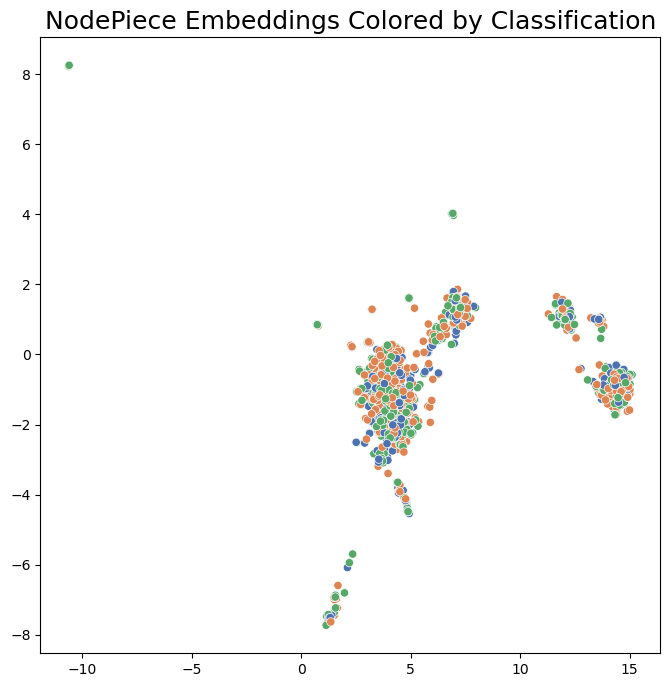

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
sns.set(font_scale=1)

palette = {}
for n, i in enumerate(set([0, 1, 2])):
    palette[i] = f'C{n}'
    
sns.scatterplot(ax=axs, x=embd_x.T[0], y=embd_x.T[1], hue=df["y"], palette=palette)
axs.get_legend().remove()
plt.title("NodePiece Embeddings Colored by Classification", fontsize=18)

plt.show()